# Frozen Lake and $Q$-learning

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).

Reinforcement learning (`RL`) is an area of machine learning concerned with how intelligent agents ought to take _actions_ in an _environment_ in order to _maximize the notion of cumulative reward_, being one of three basic machine learning paradigms, alongside Supervised learning and Unsupervised.

![pacman-gif](https://miro.medium.com/max/1274/1*D7JNcbvhP5UOR6_Ul-WJaw.gif)

$Q$-learning is a model-free reinforcement learning algorithm to learn the value of an action in a particular state. Model-free means that the agent does not require a model of the environment (the transition function that maps actions to world-states ($observation,\;reward$)), and it can handle problems with stochastic transitions and rewards without requiring adaptations.

The core of the algorithm is a [Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation.)

$$Q(s,a)^{New}=Q_{old}(s,a')+\alpha\left[R(s) + \gamma (\underset{a'}{\max}\: Q_{old}(s,a') - Q_{old}(s,a')) \right]$$

It guarantees that for any finite [Markov decision process](https://en.wikipedia.org/wiki/Markov_decision_process) (FMDP), $Q$-learning can identify an optimal action-selection policy ($\pi^{*}$), given infinite exploration time and a partly-random policy.

Frozen Lake

FrozenLake is an environment from the [Gymnasium](https://gymnasium.farama.org/) (_a maintained fork of OpenAI’s Gym library_), being a simple environment composed of tiles. The objective is to move from an initial tile to a `goal`. Tiles can be a safe `frozen lake` ❄️, or a `hole` 💀 (_terminates the game_). The AI agent, has 4 possible `actions`: go ◀️LEFT, 🔽DOWN, ▶️RIGHT, or 🔼UP, and 16 possible `word-states` in the orginal enviroment (_if you want, you can costumize your own more dangerous frozen lake_).

```
S F F F       (S: starting point, safe)
F H F H       (F: frozen surface, safe)
F F F H       (H: hole, stuck forever)
H F F G       (G: goal, safe)

👾 ❄️ ❄️ ❄️
❄️ 💀 ❄️ 💀
❄️ ❄️ ❄️ 💀
💀 ❄️ ❄️ 🏁


```

One possible correct solution is RIGHT → RIGHT → DOWN → DOWN → DOWN → RIGHT

```

👾 ▶️ ▶️ ❄️
❄️ 💀 🔽 💀
❄️ ❄️ 🔽 💀
💀 ❄️ ▶️ 🏁


```

There are different ways you can render the `FrozenLake-v1` environment. You can generate, for example, an `rgb_array` to plot a nice looking image.

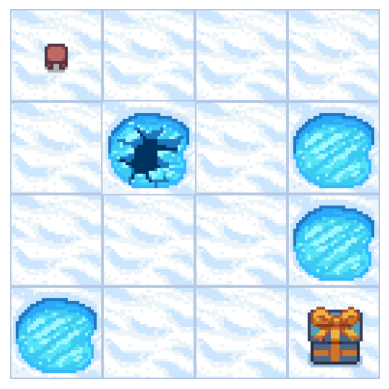

In [14]:
import time
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

%matplotlib inline

environment = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")
environment.reset()
img = plt.imshow(environment.render())
plt.axis('off')
for i in range(10):
    img.set_data(environment.render())
    display(plt.gcf())
    clear_output(wait=True)
    environment.step(environment.action_space.sample())
    time.sleep(0.5)
    if i < 9:
        clear_output(wait=True)

environment.close()


Or you could generate a `string` to print the environment.

In [15]:
environment = gym.make("FrozenLake-v1", is_slippery=False, render_mode="ansi")
environment.reset()
print(environment.render())
for i in range(10):
    print(environment.render())
    clear_output(wait=True)
    environment.step(environment.action_space.sample())
    time.sleep(0.5)
    if i < 9:
        clear_output(wait=True)

environment.close()

  (Down)
SFFF
FHFH
FFFH
HFFG



You could also open the environment as a pop-up using the `render_mode="human"`. However, we will stick with the simple `ansi` mode for now. For more information on the different environments in the `Gymnasium`, read [their documentation](https://gymnasium.farama.org/).

To recap, `FrozenLake-v1` is a discrete environment, with a space of possible actions equal to 4, and 16 possible world-states.

In [16]:
print("\n" + str(type(environment.action_space)))
print(f"Action space (a): {environment.action_space}")
print(f"Possible world-states (s): {environment.observation_space}")


<class 'gymnasium.spaces.discrete.Discrete'>
Action space (a): Discrete(4)
Possible world-states (s): Discrete(16)


One way to solve Frozen Lake is to learn which action you should choose in every state. To know which action is the best in a given state, we would like to assign a quality value ($Q(a, s)$) to our actions. Since we have 16 states and 4 actions, there are 64 values to be learned.

$Q$-Table

```
    ◀️LEFT    🔽DOWN    ▶️RIGHT   🔼UP
S1     ❓         ❓         ❓      ❓
S2     ❓         ❓         ❓      ❓
S3     ❓         ❓         ❓      ❓
S4     ❓         ❓         ❓      ❓
S5     ❓         ❓         ❓      ❓
S6     ❓         ❓         ❓      ❓
S7     ❓         ❓         ❓      ❓
S8     ❓         ❓         ❓      ❓
S9     ❓         ❓         ❓      ❓
S10    ❓         ❓         ❓      ❓
S11    ❓         ❓         ❓      ❓
S12    ❓         ❓         ❓      ❓
S13    ❓         ❓         ❓      ❓
S14    ❓         ❓         ❓      ❓
S15    ❓         ❓         ❓      ❓
S16    ❓         ❓         ❓      ❓

```

In this $Q$-table, each cell contains a value $Q(s, a)$, which is _"quality"_ of the action $a$ in the state $s$ ($1$ is the best action possible, 0 is a really bad action).

```
s           ◀️LEFT    🔽DOWN    ▶️RIGHT   🔼UP
S1        Q(1,◀️)   Q(1,🔽)   Q(1,▶️)   Q(1,🔼)
S2        Q(2,◀️)   Q(2,🔽)   Q(2,▶️)   Q(2,🔼)
S3        Q(3,◀️)   Q(3,🔽)   Q(3,▶️)   Q(3,🔼)
S4        Q(4,◀️)   Q(4,🔽)   Q(4,▶️)   Q(4,🔼)
S5        Q(5,◀️)   Q(5,🔽)   Q(5,▶️)   Q(5,🔼)
S6        Q(6,◀️)   Q(6,🔽)   Q(6,▶️)   Q(6,🔼)
S7        Q(7,◀️)   Q(7,🔽)   Q(7,▶️)   Q(7,🔼)
S8        Q(8,◀️)   Q(8,🔽)   Q(8,▶️)   Q(8,🔼)
S9        Q(9,◀️)   Q(9,🔽)   Q(9,▶️)   Q(9,🔼)
S10      Q(10,◀️)  Q(10,🔽)  Q(10,▶️)  Q(10,🔼)
S11      Q(11,◀️)  Q(11,🔽)  Q(11,▶️)  Q(11,🔼)
S12      Q(12,◀️)  Q(12,🔽)  Q(12,▶️)  Q(12,🔼)
S13      Q(13,◀️)  Q(13,🔽)  Q(13,▶️)  Q(13,🔼)
S14      Q(14,◀️)  Q(14,🔽)  Q(14,▶️)  Q(14,🔼)
S15      Q(15,◀️)  Q(15,🔽)  Q(15,▶️)  Q(15,🔼)
S16      Q(16,◀️)  Q(16,🔽)  Q(16,▶️)  Q(16,🔼)

```

For now, our $Q$-table is just filled with zeros since we have no idea of the value of each action in each state.


In [17]:
import numpy as np
import pandas as pd
from IPython.display import Markdown

qtable = np.zeros((environment.observation_space.n,
                  environment.action_space.n))
df = pd.DataFrame(qtable, index=[f'state {i+1}' for i in range(16)],
                  columns=['◀️LEFT', '🔽DOWN', '▶️RIGHT', '🔼UP'])

print('Initial Q-table')
display(Markdown(df.to_markdown()))


Initial Q-table


|          |   ◀️LEFT |   🔽DOWN |   ▶️RIGHT |   🔼UP |
|:---------|--------:|---------:|---------:|-------:|
| state 1  |       0 |        0 |        0 |      0 |
| state 2  |       0 |        0 |        0 |      0 |
| state 3  |       0 |        0 |        0 |      0 |
| state 4  |       0 |        0 |        0 |      0 |
| state 5  |       0 |        0 |        0 |      0 |
| state 6  |       0 |        0 |        0 |      0 |
| state 7  |       0 |        0 |        0 |      0 |
| state 8  |       0 |        0 |        0 |      0 |
| state 9  |       0 |        0 |        0 |      0 |
| state 10 |       0 |        0 |        0 |      0 |
| state 11 |       0 |        0 |        0 |      0 |
| state 12 |       0 |        0 |        0 |      0 |
| state 13 |       0 |        0 |        0 |      0 |
| state 14 |       0 |        0 |        0 |      0 |
| state 15 |       0 |        0 |        0 |      0 |
| state 16 |       0 |        0 |        0 |      0 |

We can randomly sample actions from this environment with the `environment.action_space.sample()` method.


In [5]:
for i in range(4):
    print(environment.action_space.sample())


3
1
0
3


_Translating..._

```

◀️ LEFT = 0
🔽 DOWN = 1
▶️ RIGHT = 2
🔼 UP = 3

```

Now that you know the commands to control the agent, you can manually specify a sequence of actions that lead to the goal.

Note: _the agent is not rendered on top of the goal because as soon as it chooses the action to reach its goal (in the final state), the episode ends._


In [6]:
environment.reset()
for_the_win = [2, 2, 1, 1, 1, 2]
for i in range(len(for_the_win)):
    print(environment.render())
    environment.step(for_the_win[i])
    time.sleep(0.5)
    if i < len(for_the_win) - 1:
        clear_output(wait=True)

print('You win!')


  (Down)
SFFF
FHFH
FFFH
HFFG

You win!


In Frozen Lake, the agent is only rewarded when it reaches the final state 🏁. It is a very simple and sparse reward function (1 when the agent reaches 🏁, and 0 otherwise).


In [7]:
environment.reset()
for_the_win = [2, 2, 1, 1, 1, 2]
for i in range(len(for_the_win)):
    print(environment.render())
    new_state, reward, done, info, prob = environment.step(for_the_win[i])
    print(f'Reward = {reward}')
    time.sleep(0.5)
    if i < len(for_the_win) - 1:
        clear_output(wait=True)
print('You win!')

  (Down)
SFFF
FHFH
FFFH
HFFG

Reward = 1.0
You win!


The scarcity of rewards is exactly one of the problems that RL needs to solve. This phenomenon, called _sparse rewards_, makes it very challenging to train agents on problems where the only reward is at the end of a long sequence of actions.

Once we get lucky enough to find the goal 🏁 by accident, we need to backpropagate the information to the other world-states, to update our $Q$-table. The $Q$-learning algorithm offers a solution to this issue. It tells us to update the value of our state-action pairs (each cell in the Q-table) considering the reward for reaching the next state, and the highest possible value in the next state.

Thus, we want that when the agent reaches the goal and receives a reward, the next time the agent interacts with the environment, the pair $Q(s, a)$ responsible for leading the agent to the goal, receives a value greater than zero, and so on for all pairs $Q(s, a)$ that direct the agent to🏁.

The update formula for our $Q$-table is:

$$Q(s,a)^{New}=Q_{old}(s,a') + R(s)+ \underset{a'}{\max}\: Q_{old}(s,a')$$

The new value is the current one + the reward + the highest value in the next state. If the agent was in the world-state previous to the goal, the $Q(s,a)$ for the action that would get it to the final state would be:

$$1 = 0 + 1 + 0$$

Since our $Q$-table is empty, the old value of $Q(s,a)$ is 0, and the reward it gets from going to the final state is 1.

If we repeat this process until the value of the final state reaches the initial-state, we get a $Q$-table like this:

```
s           ◀️LEFT    🔽DOWN    ▶️RIGHT   🔼UP
S1             0          0         1        0
S2             0          0         1        0
S3             0          1         0        0
S4             0          0         0        0
S5             0          0         0        0
S6             0          0         0        0
S7             0          1         0        0
S8             0          0         0        0
S9             0          0         0        0
S10            0          0         0        0
S11            0          1         0        0
S12            0          0         0        0
S13            0          0         0        0
S14            0          0         0        0
S15            0          0         1        0
S16            0          0         0        0

```

However, the original $Q$-learning update formula adds two (hyper)parameters:

- the `learning rate` $\alpha$ (between 0 and 1), which is how much we should change the original $Q(s,a)$ value. If $\alpha$ = 0, the value never changes, and if $\alpha$ = 1, the value changes extremely fast. This paremeter controls _the importance of past and new knowledge_.

- the discount factor $\gamma$ (between 0 and 1), which determines how much the agent cares about future rewards compared to immediate ones. If $\gamma$ = 0, the agent only focuses on immediate rewards, and if $\gamma$ = 1, any potential future reward has the same value than current ones. In Frozen Lake, since the only true reward comes at the end of the game, we want a high discount factor.

The real $Q$-learning algorithm looks like this:

$$Q(s,a)^{New}=Q_{old}(s,a')+\alpha\left[R(s) + \gamma (\underset{a'}{\max}\: Q_{old}(s,a') - Q_{old}(s,a')) \right]$$

Again, it the agent is next to the goal 🏁 for the first time, we can update the state-action pair to win the game using $Q$-learning algorithm:

$$Q^{new}(s_{before \; goal}, a_{\rightarrow}) = 0 + \alpha \times (1 + \gamma \times 0 - 0)$$

With an $\alpha$ = 0.5 and $\gamma$ = 0.9, we get:

$$Q^{new}(s_{before \; goal}, a_{\rightarrow}) = 0 + 0.5 \times (1 + 0.9 \times 0 - 0) = 0.5$$

The second time the agent is in this state (since the $Q$-function would be updated) we would get:

$$Q^{new}(s_{before \; goal}, a_{\rightarrow}) = 0.5 + 0.5 \times (1 + 0.9 \times 0 - 0.5) = 0.75$$

Now let's do all of this in code.


In [18]:
import plotly.graph_objects as go
qtable = np.zeros(
    (environment.observation_space.n, environment.action_space.n))
df = pd.DataFrame(qtable, index=[f'state {i+1}' for i in range(16)],
                  columns=['◀️LEFT', '🔽DOWN', '▶️RIGHT', '🔼UP'])

episodes = 1000
alpha = 0.5
gamma = 0.9

outcomes = []

print('Q-table before training:')
display(Markdown(df.to_markdown()))

# Training
for _ in range(episodes):
    state, _ = environment.reset()
    done = False

    outcomes.append(0)

    while not done:
        # if you want to render the experiment, lower the number of episodes
        #print(environment.render())
        if np.max(qtable[state]) > 0:
            # Choose the action with the highest value in the current state
            action = np.argmax(qtable[state])
        else:
            # If there's no best action (only zeros), take a random one
            action = environment.action_space.sample()

        new_state, reward, done, info, prob = environment.step(action)

        # if you want to render the experiment, uncomment the next lines
        #time.sleep(0.5)
        #clear_output(wait=True)
        #if done == False:
        #    clear_output(wait=True)

        # Update Q(s,a)
        qtable[state, action] = qtable[state, action] + alpha * \
            (reward + gamma *
             np.max(qtable[new_state]) - qtable[state, action])

        state = new_state

        # If we have a reward, it means that our outcome is a success
        if reward:
            outcomes.append(1)


df = pd.DataFrame(qtable, index=[f'state {i+1}' for i in range(16)],
                  columns=['◀️LEFT', '🔽DOWN', '▶️RIGHT', '🔼UP'])

print('Q-table after training:')
display(Markdown(df.to_markdown()))

fig = go.Figure()
fig.add_trace(go.Bar(x=list(range(0, len(outcomes))), y=outcomes, marker_color='red'))
fig.update_layout(
    template='plotly_dark',
    hoverlabel=dict(
        bgcolor='rgba(0, 0, 0, 0.8)'
    ),
    title=f'Success rate = {(sum(outcomes)/episodes)*100}%',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    plot_bgcolor='rgba(0, 0, 0, 0)'
)
fig.show()


Q-table before training:


|          |   ◀️LEFT |   🔽DOWN |   ▶️RIGHT |   🔼UP |
|:---------|--------:|---------:|---------:|-------:|
| state 1  |       0 |        0 |        0 |      0 |
| state 2  |       0 |        0 |        0 |      0 |
| state 3  |       0 |        0 |        0 |      0 |
| state 4  |       0 |        0 |        0 |      0 |
| state 5  |       0 |        0 |        0 |      0 |
| state 6  |       0 |        0 |        0 |      0 |
| state 7  |       0 |        0 |        0 |      0 |
| state 8  |       0 |        0 |        0 |      0 |
| state 9  |       0 |        0 |        0 |      0 |
| state 10 |       0 |        0 |        0 |      0 |
| state 11 |       0 |        0 |        0 |      0 |
| state 12 |       0 |        0 |        0 |      0 |
| state 13 |       0 |        0 |        0 |      0 |
| state 14 |       0 |        0 |        0 |      0 |
| state 15 |       0 |        0 |        0 |      0 |
| state 16 |       0 |        0 |        0 |      0 |

Q-table after training:


|          |   ◀️LEFT |   🔽DOWN |   ▶️RIGHT |   🔼UP |
|:---------|--------:|---------:|---------:|-------:|
| state 1  |       0 |  0.59049 |    0     |      0 |
| state 2  |       0 |  0       |    0     |      0 |
| state 3  |       0 |  0       |    0     |      0 |
| state 4  |       0 |  0       |    0     |      0 |
| state 5  |       0 |  0.6561  |    0     |      0 |
| state 6  |       0 |  0       |    0     |      0 |
| state 7  |       0 |  0       |    0     |      0 |
| state 8  |       0 |  0       |    0     |      0 |
| state 9  |       0 |  0       |    0.729 |      0 |
| state 10 |       0 |  0       |    0.81  |      0 |
| state 11 |       0 |  0.9     |    0     |      0 |
| state 12 |       0 |  0       |    0     |      0 |
| state 13 |       0 |  0       |    0     |      0 |
| state 14 |       0 |  0       |    0     |      0 |
| state 15 |       0 |  0       |    1     |      0 |
| state 16 |       0 |  0       |    0     |      0 |

Now that the agent has been trained, let us evaluate the agent's performance on 10 episodes.


In [10]:
episodes = 10
success_rate = 0

# Evaluation
for _ in range(episodes):
    state, _ = environment.reset()
    done = False

    while not done:
        print(environment.render())
        if np.max(qtable[state]) > 0:
            action = np.argmax(qtable[state])

        else:
            action = environment.action_space.sample()

        new_state, reward, done, info, prob = environment.step(action)

        time.sleep(0.1)
        if done == False:
            clear_output(wait=True)

        state = new_state

        success_rate += reward

# Let's check our success rate!
print(f'Success rate = {(success_rate/episodes)*100}%')


  (Down)
SFFF
FHFH
FFFH
HFFG

Success rate = 100.0%


## _Getting Greedy_

With this implementation, the agent will always choose the action with the highest value. So whenever a state-action pair starts having a non-zero value, the agent will always choose it. The other actions will never be taken, which means we’ll never update their value. If you want to incentivize exploration, we can use an $\epsilon$-Greedy approach.

In RL, we can divide the "_behavior_" of our agent between exploitation (_taking the action with the highest value_) and exploration (_choosing a random action to try to find even better ones_).

A trade-off between these two behaviors is important: if the agent only focuses on exploitation, it cannot try new solutions and thus doesn’t learn anymore. On the other hand, if the agent only takes random actions, the training is pointless since it doesn’t use the knowledge of the $Q$-function.

The $\epsilon$-Greedy algorithm is a way to find this balance.

- Every time the agent has to take an action $a$, it has a probability $\epsilon$ of choosing a random action, and a probability $1 - \epsilon$ of choosing the one with the highest value.
- We can decrease the value of $\epsilon$ at the end of each episode by a fixed amount (_linear decay_), or based on the current value of $\epsilon$ (_exponential decay_).


In [19]:
qtable = np.zeros((environment.observation_space.n,
                  environment.action_space.n))
df = pd.DataFrame(qtable, index=[f'state {i+1}' for i in range(16)],
                  columns=['◀️LEFT', '🔽DOWN', '▶️RIGHT', '🔼UP'])


episodes = 2000
alpha = 0.5
gamma = 0.9
epsilon = 1.0         # start with full exploration mode
epsilon_decay = 0.001  # decay epsilon by this amount

outcomes = []

print('Q-table before training:')
display(Markdown(df.to_markdown()))

# Training
for _ in range(episodes):
    state, _ = environment.reset()
    done = False
    outcomes.append(0)

    while not done:
        # Generate a random number between 0 and 1
        rnd = np.random.random()

        # If random number < epsilon, take a random action
        if rnd < epsilon:

            action = environment.action_space.sample()
        # Else, take the action with the highest value in the current state
        else:

            action = np.argmax(qtable[state])

        new_state, reward, done, info, proba = environment.step(action)

        qtable[state, action] = qtable[state, action] + alpha * \
            (reward + gamma *
             np.max(qtable[new_state]) - qtable[state, action])

        state = new_state
        if reward:
            outcomes.append(1)

    # Update epsilon
    epsilon = max(epsilon - epsilon_decay, 0)

df = pd.DataFrame(qtable, index=[f'state {i+1}' for i in range(16)],
                  columns=['◀️LEFT', '🔽DOWN', '▶️RIGHT', '🔼UP'])

print('Q-table after training:')
display(Markdown(df.to_markdown()))

fig = go.Figure()
fig.add_trace(go.Bar(x=list(range(0, len(outcomes))), y=outcomes, marker_color='red'))
fig.update_layout(
    template='plotly_dark',
    hoverlabel=dict(
        bgcolor='rgba(0, 0, 0, 0.8)'
    ),
    title=f'Success rate = {(sum(outcomes)/episodes)*100}%',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    plot_bgcolor='rgba(0, 0, 0, 0)'
)
fig.show()


Q-table before training:


|          |   ◀️LEFT |   🔽DOWN |   ▶️RIGHT |   🔼UP |
|:---------|--------:|---------:|---------:|-------:|
| state 1  |       0 |        0 |        0 |      0 |
| state 2  |       0 |        0 |        0 |      0 |
| state 3  |       0 |        0 |        0 |      0 |
| state 4  |       0 |        0 |        0 |      0 |
| state 5  |       0 |        0 |        0 |      0 |
| state 6  |       0 |        0 |        0 |      0 |
| state 7  |       0 |        0 |        0 |      0 |
| state 8  |       0 |        0 |        0 |      0 |
| state 9  |       0 |        0 |        0 |      0 |
| state 10 |       0 |        0 |        0 |      0 |
| state 11 |       0 |        0 |        0 |      0 |
| state 12 |       0 |        0 |        0 |      0 |
| state 13 |       0 |        0 |        0 |      0 |
| state 14 |       0 |        0 |        0 |      0 |
| state 15 |       0 |        0 |        0 |      0 |
| state 16 |       0 |        0 |        0 |      0 |

Q-table after training:


|          |    ◀️LEFT |   🔽DOWN |   ▶️RIGHT |     🔼UP |
|:---------|---------:|---------:|---------:|---------:|
| state 1  | 0.531441 |  0.59049 | 0.59049  | 0.531441 |
| state 2  | 0.531441 |  0       | 0.6561   | 0.589362 |
| state 3  | 0.587302 |  0.729   | 0.556957 | 0.654374 |
| state 4  | 0.649145 |  0       | 0.473544 | 0.346522 |
| state 5  | 0.59049  |  0.6561  | 0        | 0.531441 |
| state 6  | 0        |  0       | 0        | 0        |
| state 7  | 0        |  0.81    | 0        | 0.619722 |
| state 8  | 0        |  0       | 0        | 0        |
| state 9  | 0.6561   |  0       | 0.729    | 0.59049  |
| state 10 | 0.6561   |  0.81    | 0.81     | 0        |
| state 11 | 0.728951 |  0.9     | 0        | 0.72893  |
| state 12 | 0        |  0       | 0        | 0        |
| state 13 | 0        |  0       | 0        | 0        |
| state 14 | 0        |  0.81    | 0.9      | 0.729    |
| state 15 | 0.81     |  0.9     | 1        | 0.81     |
| state 16 | 0        |  0       | 0        | 0        |

Our success rate during training is _much lower_ now, and it takes _longer for the agent to find optimal solutions for Fronzen Lake_. However, our $Q$-table is much _more complete_, and our agent has probably learned _new strategies/paths_.


In [12]:
episodes = 10
success_rate = 0

# Evaluation
for _ in range(episodes):
    state, _ = environment.reset()
    done = False

    while not done:
        print(environment.render())
        if np.max(qtable[state]) > 0:
            action = np.argmax(qtable[state])

        else:
            action = environment.action_space.sample()

        new_state, reward, done, info, prob = environment.step(action)

        time.sleep(0.1)
        if done == False:
            clear_output(wait=True)

        state = new_state

        success_rate += reward

# Let's check our success rate!
print(f'Success rate = {(success_rate/episodes)*100}%')


  (Right)
SFFF
FHFH
FFFH
HFFG

Success rate = 100.0%


## ❄️Frozen and Slippery❄️

The Frozen Lake environment has a variant where, even if the agent chooses to take action $X$, there is a probability that the action performed is $Y$. This is what we call slippery mode (`is_slippery = True`). In the slippery variant, the action the agent takes only has 33% chance of succeeding. This feature makes things more difficult for our agent.


In [12]:
environment = gym.make("FrozenLake-v1", is_slippery=True, render_mode="ansi")
environment.reset()

qtable = np.zeros((environment.observation_space.n,
                  environment.action_space.n))
df = pd.DataFrame(qtable, index=[f'state {i+1}' for i in range(16)],
                  columns=['◀️LEFT', '🔽DOWN', '▶️RIGHT', '🔼UP'])

episodes = 5000
alpha = 0.5
gamma = 0.9
epsilon = 1.0
epsilon_decay = 0.001

outcomes = []

print('Q-table before training:')
display(Markdown(df.to_markdown()))

# Training
for _ in range(episodes):
    state, _ = environment.reset()
    done = False

    outcomes.append(0)

    while not done:
        rnd = np.random.random()

        if rnd < epsilon:
            action = environment.action_space.sample()
        else:
            action = np.argmax(qtable[state])

        new_state, reward, done, info, prob = environment.step(action)

        qtable[state, action] = qtable[state, action] + alpha * \
            (reward + gamma *
             np.max(qtable[new_state]) - qtable[state, action])

        state = new_state

        if reward:
            outcomes.append(1)

    epsilon = max(epsilon - epsilon_decay, 0)

df = pd.DataFrame(qtable, index=[f'state {i+1}' for i in range(16)],
                  columns=['◀️LEFT', '🔽DOWN', '▶️RIGHT', '🔼UP'])

print('Q-table after training:')
display(Markdown(df.to_markdown()))

fig = go.Figure()
fig.add_trace(go.Bar(x=list(range(0, len(outcomes))), y=outcomes, marker_color='red'))
fig.update_layout(
    template='plotly_dark',
    hoverlabel=dict(
        bgcolor='rgba(0, 0, 0, 0.8)'
    ),
    title=f'Success rate = {(sum(outcomes)/episodes)*100}%',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    plot_bgcolor='rgba(0, 0, 0, 0)'
)
fig.show()


Q-table before training:


|          |   ◀️LEFT |   🔽DOWN |   ▶️RIGHT |   🔼UP |
|:---------|--------:|---------:|---------:|-------:|
| state 1  |       0 |        0 |        0 |      0 |
| state 2  |       0 |        0 |        0 |      0 |
| state 3  |       0 |        0 |        0 |      0 |
| state 4  |       0 |        0 |        0 |      0 |
| state 5  |       0 |        0 |        0 |      0 |
| state 6  |       0 |        0 |        0 |      0 |
| state 7  |       0 |        0 |        0 |      0 |
| state 8  |       0 |        0 |        0 |      0 |
| state 9  |       0 |        0 |        0 |      0 |
| state 10 |       0 |        0 |        0 |      0 |
| state 11 |       0 |        0 |        0 |      0 |
| state 12 |       0 |        0 |        0 |      0 |
| state 13 |       0 |        0 |        0 |      0 |
| state 14 |       0 |        0 |        0 |      0 |
| state 15 |       0 |        0 |        0 |      0 |
| state 16 |       0 |        0 |        0 |      0 |

Q-table after training:


|          |      ◀️LEFT |      🔽DOWN |      ▶️RIGHT |        🔼UP |
|:---------|-----------:|------------:|------------:|------------:|
| state 1  | 0.0803561  | 0.00469287  | 0.00516152  | 0.00448162  |
| state 2  | 0.00249413 | 0.00243242  | 0.00147596  | 0.0847136   |
| state 3  | 0.00168383 | 0.00197408  | 0.00197842  | 0.0448106   |
| state 4  | 0.0010475  | 0.00140342  | 0.0015119   | 0.0268532   |
| state 5  | 0.140077   | 0.00443677  | 0.00583232  | 0.00650307  |
| state 6  | 0          | 0           | 0           | 0           |
| state 7  | 0.0597906  | 0.000358543 | 0.000340009 | 0.000245556 |
| state 8  | 0          | 0           | 0           | 0           |
| state 9  | 0.0082566  | 0.0115445   | 0.00923823  | 0.255889    |
| state 10 | 0.0189049  | 0.308944    | 0.0233541   | 0.0222213   |
| state 11 | 0.432525   | 0.00702759  | 0.00865208  | 0.00925413  |
| state 12 | 0          | 0           | 0           | 0           |
| state 13 | 0          | 0           | 0           | 0           |
| state 14 | 0.0661875  | 0.0693675   | 0.514662    | 0.0474348   |
| state 15 | 0.12291    | 0.851701    | 0.132801    | 0.114103    |
| state 16 | 0          | 0           | 0           | 0           |

Let us test our new agent in this slippery environment.

In [14]:
episodes = 10
success_rate = 0

# Evaluation
for _ in range(episodes):
    state,_ = environment.reset()
    done = False

    while not done:
        print(environment.render())
        if np.max(qtable[state]) > 0:
            action = np.argmax(qtable[state])

        else:
            action = environment.action_space.sample()

        new_state, reward, done, info, prob = environment.step(action)

        time.sleep(0.1)
        if done == False:
            clear_output(wait=True)

        state = new_state

        success_rate += reward

# Let's check our success rate!
print(f'Success rate = {(success_rate/episodes)*100}%')


  (Left)
SFFF
FHFH
FFFH
HFFG

Success rate = 50.0%


You can try to tweak the hyperparameters to get a better result. Since we are dealing with an extremely stochastic environment, it might be better to decrease the initial epsilon value (e.g., 0.7). However, one problem RL faces is that the final result of an agent is _extremely sensitive to the choice of hyperparameters_, something that makes RL more difficult to get right when compared to, for example, vanilla supervised learning.

---

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).
